In [11]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

In [29]:
bs = pd.read_csv("./SVM5G_Datasets/BS.csv")
users = pd.read_csv("./SVM5G_Datasets/Users.csv")

In [69]:
# Defining l0 (used in path loss computation)
d0 = 1
f = 24 # Gh
l0 = 10*math.log10(((4 * math.pi * d0)/f)**2)

# Frequency slicing [kHz]
Dfc = 30

# Number of subcarrier
nSubCarrier = 12

# Time slicing [ms]
Dt = 1

# Bandwidth [kHz]
Wprb = Dfc * nSubCarrier

# Number of physical resource blocks
Nprb = 25

# Number of symbol
nSymbol = 13

# Number of users to generate
totUsers = 100

# IoT users percent (of totUsers)
iotUsersPercent = 0.9

# MMB users percent (of totUsers)
mmbUsersPercent = 1.0 - iotUsersPercent

# IoT users
iotUsers = round(totUsers*iotUsersPercent)

# MMB users
mmbUsers = round(totUsers*mmbUsersPercent)



90 10


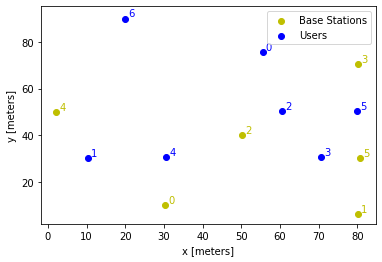

In [55]:
def plotPositions(users, bs, connections = None):

    BSPos = bs[['BSLat','BSLon']]
    UPos = users[['ULat','ULon']]

    fig, ax = plt.subplots()
    
    # Plotting BS and Users positions 
    ax.scatter(BSPos['BSLon'],BSPos['BSLat'], color='y')
    ax.scatter(UPos['ULon'], UPos['ULat'], color='b')
    plt.ylabel('y [meters]')
    plt.xlabel('x [meters]')
    ax.legend(['Base Stations', 'Users'])
    
    for i,j in bs.iterrows():
        
        # Plotting BS range
        #pos = (j['BSLon'], j['BSLat'])
        #circle = plt.Circle(pos, j['BSRange'], color='y', fill=False)
        #ax.add_artist(circle)
        
        #Plotting BS index
        ax.annotate(i, (j['BSLon']+0.8, j['BSLat']+0.8), color='y')
        
    for i,j in users.iterrows():
        
        #Plotting user index
        ax.annotate(i, (j['ULon']+0.8, j['ULat']+0.8), color='b')
        #ax.annotate(j['UDataRate'], (j['ULon']-0.1, j['ULat']-0.1), color='b')

    if(connections is not None):
        for ui, uj  in connections.iterrows():
            if(not math.isinf(uj['minPathLoss'])):
                bsi = int(uj['BS'])
                lat1, lat2 = UPos.iloc[ui]['ULat'], BSPos.iloc[bsi]['BSLat']
                lon1, lon2 = UPos.iloc[ui]['ULon'], BSPos.iloc[bsi]['BSLon']
                ax.plot([lon1,lon2],[lat1,lat2], color='b', alpha=0.2)
        
                # Plotting BS range
                pos = (users.loc[int(ui), 'ULon'], users.loc[int(ui), 'ULat'])
                circle = plt.Circle(pos, uj['minPathLoss'], color='b', fill=False, alpha=0.1)
                ax.add_artist(circle)
        
plotPositions(users, bs)

Computing distances between users (rows) and BS (columns):

In [63]:
def computeDistance(lat1, lon1, lat2, lon2):
    return math.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

def computePathLoss(distance, gamma = 3):
    return l0 + 10*gamma*math.log10(distance)

def computePathLosses():
    pathLosses = pd.DataFrame()
    for ui,uj in users.iterrows():
        for bsi,bsj in bs.iterrows():
            dist = computeDistance(uj['ULat'], uj['ULon'], bsj['BSLat'], bsj['BSLon'])
            pathLoss = computePathLoss(dist)
            pathLosses.at[ui,bsi] = pathLoss
            
    return pathLosses
        

pathLosses = computePathLosses()
    
pathLosses.head(20)

,0,1,2,3,4,5
0,49.745374,50.353974,40.936216,36.431810,47.527220,45.831534
1,37.965391,50.415604,42.806031,51.572120,34.391875,49.821950
2,45.446177,44.893460,29.204576,37.815384,47.370287,38.104258
3,44.068571,36.990524,34.918297,42.660324,49.947337,24.654143
4,33.903557,46.671885,34.545095,48.462323,40.448691,45.425612
5,48.549051,43.683586,39.310847,33.463467,51.126127,33.505311
6,51.562553,54.767348,47.325484,48.421619,43.587404,52.304300


In [64]:
minPathLosses = pd.DataFrame()
minPathLosses['BS'] = pathLosses.idxmin(axis=1)
minPathLosses['minPathLoss'] = pathLosses.min(axis=1)

minPathLosses.head(20)

,BS,minPathLoss
0,3,36.431810
1,4,34.391875
2,2,29.204576
3,5,24.654143
4,0,33.903557
5,3,33.463467
6,4,43.587404


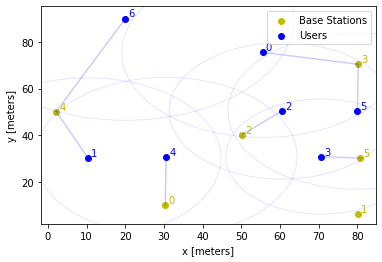

In [65]:
plotPositions(users, bs, minPathLosses)